<a href="https://colab.research.google.com/github/streetsoulZIP/stepik-dl-nlp/blob/master/dns_reviews_sent_analys.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- доделать нейросеть для мультит-классификации, сделай оглавление, п

# **Get data**

In [ ]:
data = open('data.txt', encoding='utf-8').readlines()

In [ ]:
data_dict = {'url': [], 'name': [], 'price': [], 'rating': [], 'title': [], 'desc': []}
columns_name = list(data_dict.keys())


for line in data:
    line = line.split(' _SEP_ ')
    for ind in range(len(line)):
        data_dict[columns_name[ind]].append(line[ind])

# *Imports*

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.category import UnitData
%matplotlib inline

import re, string, nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import word_tokenize

from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import tensorflow as tf
from tensorflow.keras import models,layers,optimizers
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Conv1D, GlobalMaxPooling1D
from keras.layers import Dense, Activation, Dropout, BatchNormalization, Embedding, LSTM, Bidirectional
from tensorflow import keras
from keras.models import Sequential

import warnings


pd.options.display.max_colwidth = 115

# Data preparation

In [ ]:
raw_df = pd.DataFrame(data_dict)
df = pd.DataFrame(raw_df.iloc[[0]])

In [ ]:
for i in range(1, raw_df.shape[0]):
    prev_row_desc = raw_df.iloc[i-1, 5]
    cur_row = pd.DataFrame(raw_df.iloc[[i]])
    cur_row_desc = cur_row.iloc[0, 5]
    if cur_row_desc!=prev_row_desc:
        df = pd.concat([df, cur_row], ignore_index=False)

In [ ]:
df.shape

(20141, 6)

In [ ]:
df.head()

,url,name,price,rating,title,desc
0,https://www.dns-shop.ru/product/512eb86b9c5ded20/provodnye-nausniki-exployd-ex-hp-1370-krasnyj/,Проводные наушники Exployd EX-HP-1370 красный,99,5,"['Достоинства', 'Недостатки', 'Комментарий']","['- Наушники работают', '- Не выяленно', 'К покупке рекомендую']\n"
1,https://www.dns-shop.ru/product/512eb86b9c5ded20/provodnye-nausniki-exployd-ex-hp-1370-krasnyj/,Проводные наушники Exployd EX-HP-1370 красный,99,1,"['Достоинства', 'Недостатки', 'Комментарий']","['Цена', 'Качество ниже плинтуса', 'Пропал звук в одном наушнике, не проработав и недели. Проезд до сервисного ..."
10,https://www.dns-shop.ru/product/95e458249c5ded20/provodnye-nausniki-exployd-ex-hp-1371-zeltyj/,Проводные наушники Exployd EX-HP-1371 желтый,99,2,"['Достоинства', 'Недостатки', 'Комментарий']","['Яркие', 'Дешёвые и некачественные', 'Сломались через пару дней использования. Собственно не удивлена, за таку..."
11,https://www.dns-shop.ru/product/95e458249c5ded20/provodnye-nausniki-exployd-ex-hp-1371-zeltyj/,Проводные наушники Exployd EX-HP-1371 желтый,99,5,"['Достоинства', 'Недостатки', 'Комментарий']","['Желтые. Для меня это очень важно. Есть шумоподавление. Плотно прилегают к ушам.', 'Не нашла', 'Мне очень понр..."
15,https://www.dns-shop.ru/product/ef317dce9c5ced20/provodnye-nausniki-exployd-ex-hp-1369-sinij/,Проводные наушники Exployd EX-HP-1369 синий,99,5,"['Достоинства', 'Недостатки', 'Комментарий']","['Бомбезные', 'Нету', 'Топ чо за 100 рублей имба, не жалуемся']\n"


In [ ]:
df['price'] = df['price'].apply(lambda price: int(price) if price!='-' else np.NaN)
df['rating'] = df['rating'].apply(int)

# Data analys

In [ ]:
categories = [200, 500, 1000, 2500, 5000, 10000, 15000, 20000, 25000, 50000, 100000, 250000, 500000]
order = [f"<{i}" for i in categories]
def select_price_category(price, categories=categories):
    if price==np.NaN:
        return np.NaN
    for i in categories:
        if price<i:
            return f"<{i}"
df['price_cat'] = df['price'].apply(select_price_category)

# PLOT 1

### Let's find how price category and average rating are correlated

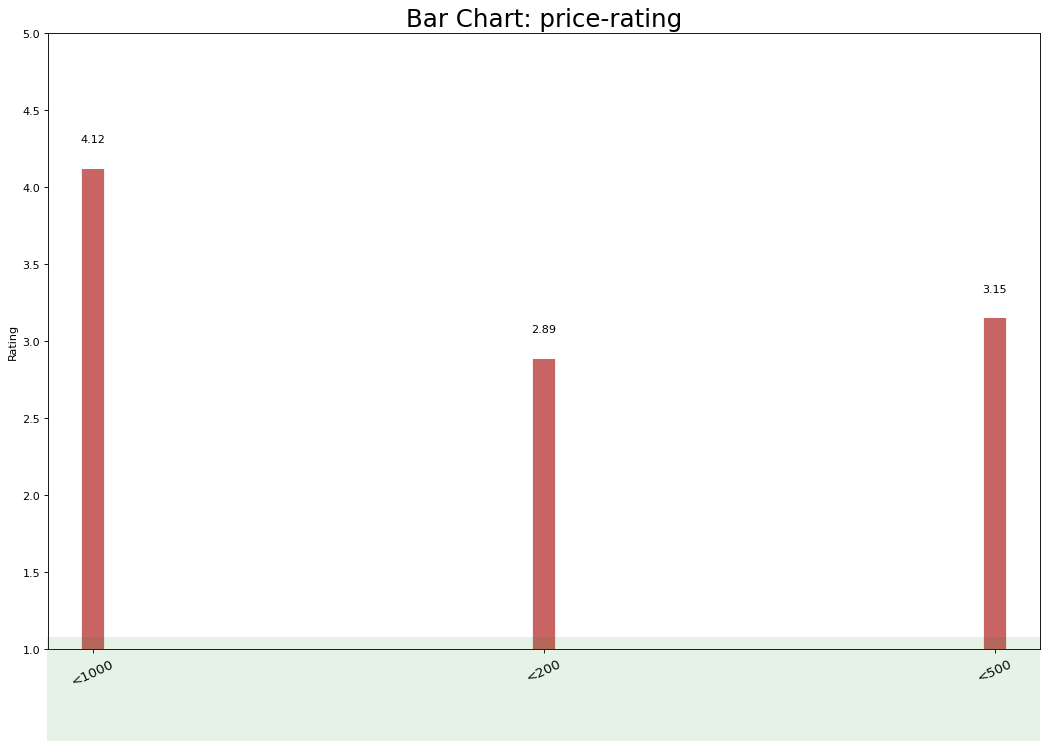

In [ ]:
def sort_price_cat(data):
    spec_order = [i for i in order if i in data['price_cat'].unique()]
    data['price_cat'] = pd.Categorical(data['price_cat'], spec_order)
    data = data.sort_values('price_cat').reset_index()
    return data

data_for_plot = df[['price_cat', 'rating']]
data_for_plot = data_for_plot[data_for_plot['price_cat'].notna()]
data_for_plot = data_for_plot.groupby('price_cat').mean().reset_index()
sort_price_cat(data_for_plot)


x = data_for_plot['price_cat']
y = data_for_plot['rating']

fig, ax = plt.subplots(figsize=(16,10), facecolor='white', dpi= 80)
ax.vlines(x=x.index, ymin=1, ymax=y, color='firebrick', alpha=0.7, linewidth=20)

for index, value in enumerate(y):
    plt.text(index, value+0.17, round(value, 2), horizontalalignment='center')

ax.set_title('Bar Chart: price-rating', fontdict={'size':22})
ax.set(ylabel='Rating', ylim=(1, 5))

plt.xticks(x.index, x, rotation=25, horizontalalignment='center', fontsize=12)
p = patches.Rectangle((.124, -0.005), width=0.776, height=.13, alpha=.1, facecolor='green', transform=fig.transFigure)
fig.add_artist(p)
plt.show()

### The average rating goes up as the price goes up to 2500, but doesn't change much after that

# PLOT 2

### Suppose a person wants to buy a product according to his budget, let's present the data in the form of a graph to help the buyer find the best product from the price category that suits him

                                                         👶


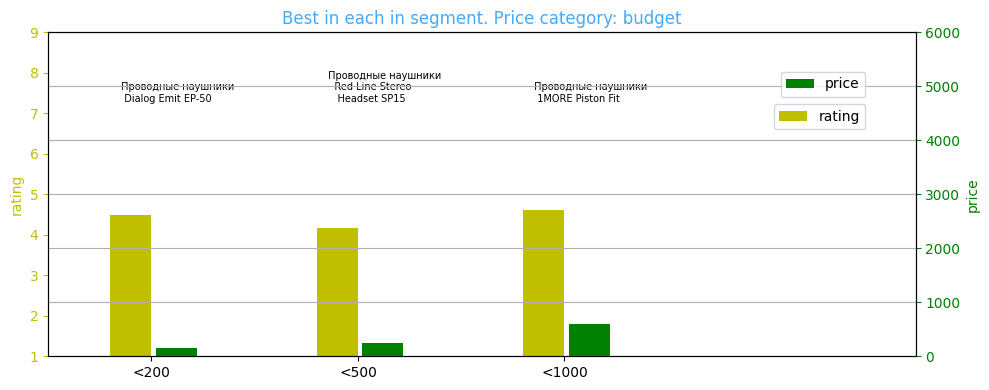

In [ ]:
data_for_plot_1 = df[['name', 'rating']].groupby('name').count().reset_index().rename(columns={'rating': 'count_reviews'})
data_for_plot_1 = data_for_plot_1[data_for_plot_1['count_reviews']>10]
data_for_plot_2 = df[['name', 'price', 'price_cat', 'rating']].groupby(['name', 'price', 'price_cat']).mean().round(2).reset_index()
data_for_plot_3 = pd.merge(data_for_plot_1, data_for_plot_2, left_on='name', right_on='name', how='inner')
data_for_plot_3 = data_for_plot_3.merge(data_for_plot_3[['price_cat', 'rating']].groupby('price_cat').max().reset_index(), left_on=['price_cat', 'rating'], right_on=['price_cat', 'rating'], how='inner')

def plot_best_in_cat(level_name, level_min, level_lim, smile, title_color, data_for_plot=data_for_plot_3):

    data_for_plot = data_for_plot[data_for_plot['price']>level_min]

    if data_for_plot.index.tolist()==[]:
        return "No values in such category"

    print(" "*57 + smile)
    data_for_plot = sort_price_cat(data_for_plot)

    color1, color2 = 'y', 'g'
    bar_width = 0.2
    gap = 0.02

    x = np.arange(len(data_for_plot['price_cat']))

    fig, ax1 = plt.subplots(figsize=(10, 4))
    bar1 = ax1.bar(x - bar_width/2, data_for_plot['rating'], bar_width, label='rating', color=color1)
    ax1.set_ylabel('rating', color=color1)
    ax1.set_title(f'Best in each in segment. Price category: {level_name}', color=title_color)
    ax1.set_xticks(x)
    ax1.tick_params(axis='y', colors=color1)
    ax1.set_xticklabels(data_for_plot['price_cat'])
    ax1.legend(bbox_to_anchor=(0.95, 0.8))
    ax1.set_ylim(1, 9)
    for i in range(len(data_for_plot)):
        item_name = ''
        piece = ''
        for word in data_for_plot['name'][i].split():
            if len(piece+word+' ')>19:
                item_name += piece.center(20) + '\n'
                piece = ''
            piece += ' ' + word

        plt.text(i-0.16, 7, item_name, fontsize = 7)

    ax2 = ax1.twinx()
    bar2 = ax2.bar(x + bar_width/2+gap, data_for_plot['price'], bar_width, label='price', color=color2)
    ax2.set_ylabel('price', color=color2)
    ax2.legend(bbox_to_anchor=(0.95, 0.9))
    ax2.set_ylim(level_min, level_lim)
    ax2.set_xlim(-0.5, len(data_for_plot)+0.7)
    ax2.tick_params(axis='y', colors=color2)
    fig.tight_layout()
    plt.grid(True)
    plt.show()

k = 1.2
classes = {f'budget': [0, 5000*k, "👶", '#42AAFF'], 'medium':[5001, 15000*k, "🐐", '#FFFF00'], 'premium':[15001, 50000*k, "😎", 'g'], 'extra premium' : [50000, 10**10*k, "🤑", 'gold']}
for level_name, level_range in classes.items():
    plot_best_in_cat(level_name, level_range[0], level_range[1], level_range[2], level_range[3])

# Preprocessing text for sentiment classification

## Data harmonization

In [ ]:
def title_prep(text):
    text = re.sub("[\[\]']", '', text)
    return [piece.replace("'", '') for piece in text.split(', ')]


def del_photo(tit):
    return [piece for piece in tit if piece!='Фото']


def desc_prep(text):
    text = re.sub("[\[\]]", '', text)
    text = re.sub("\n", '', text)
    return [piece.replace("'", '') for piece in text.split("', ")]


def fix_desc(desc):
    new_desc = []
    for piece in desc:
        piece = piece.split('",')
        for part_of_piece in piece:
            new_desc.append(part_of_piece)
    return new_desc

In [ ]:
df["title"] = df["title"].apply(title_prep).apply(del_photo)

In [ ]:
df["desc"] = df["desc"].apply(desc_prep).apply(fix_desc)

## Getting a whole review

In [ ]:
def make_review(row):
    title = row['title']
    desc = row['desc']
    return ' '.join(f"{e1} {e2}." for e1, e2 in zip(title, desc))

In [ ]:
df['full_review'] = df[['title', 'desc']].apply(make_review, axis=1)

In [ ]:
df['full_review'].head(3)

,full_review
0,Достоинства - Наушники работают. Недостатки - Не выяленно. Комментарий К покупке рекомендую.
1,"Достоинства Цена. Недостатки Качество ниже плинтуса. Комментарий Пропал звук в одном наушнике, не проработав и ..."
10,Достоинства Яркие. Недостатки Дешёвые и некачественные. Комментарий Сломались через пару дней использования. Со...


## Clean texts

In [ ]:
non_alphanum = re.compile(r'[\W]')
non_ascii = re.compile(r'[^а-я0-1\s]')
def normalize_texts(texts):
    normalized_texts = []
    for text in texts:
        text = text.lower()
        if 'www.' in text or 'http:' in text or 'https:' in text or '.com' in text:
            text = re.sub(r"([^ ]+(?<=\.[a-z]{3}))", "<url>", text)

        text = re.sub('\d','0',text)
        text = non_alphanum.sub(r' ', text)
        text = non_ascii.sub(r'', text)
        text = re.sub(r'\s+', ' ', text)

        normalized_texts.append(text)
    return normalized_texts

df['clean_reviews'] = normalize_texts(df['full_review'])

In [ ]:
df['clean_reviews'].head(8)

,clean_reviews
0,достоинства наушники работают недостатки не выяленно комментарий к покупке рекомендую
1,достоинства цена недостатки качество ниже плинтуса комментарий пропал звук в одном наушнике не проработав и нед...
10,достоинства яркие недостатки дешвые и некачественные комментарий сломались через пару дней использования собств...
11,достоинства желтые для меня это очень важно есть шумоподавление плотно прилегают к ушам недостатки не нашла ком...
15,достоинства бомбезные недостатки нету комментарий топ чо за 000 рублей имба не жалуемся
16,достоинства дешевые недостатки качество звука отвратное
17,достоинства цена недостатки недолговечностькачество звука комментарий через неделю после покупки один наушник п...
23,достоинства хорошие наушники по дешевой цене недостатки их нет комментарий брал для прослушивания музыки не хри...


# Classification

### Let's divide the evaluations in two ways: first into positive and negative (binary classification), second into positive, neutral and negative (multiclass classification)

# First way

In [ ]:
df['sentiment'] = df['rating'].apply(lambda rating: 1 if rating>=4 else 0)

## Class distribution

<ipython-input-20-90ddd8677c5f>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df['sentiment'], palette={'0': 'r', '1': 'g'})


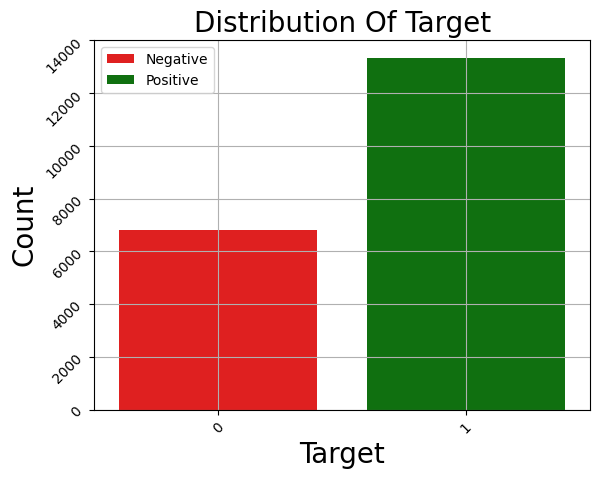

In [ ]:
sns.countplot(x=df['sentiment'], palette={'0': 'r', '1': 'g'})
plt.title('Distribution Of Target',fontsize=20)
plt.xlabel('Target',fontsize=20)
plt.ylabel('Count',fontsize=20)
plt.legend(["Negative", "Positive"])
plt.grid(True)
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

## Tokenize & vectorize texts

In [ ]:
num_words = 12000

In [ ]:
def preparatory_work(df=df):
    texts = df['clean_reviews']
    sentiment = df['sentiment']

    train_texts, test_texts, train_sent, test_sent = train_test_split(texts, sentiment, test_size=0.33, random_state=42)

    tokenizer = Tokenizer(num_words=num_words)
    tokenizer.fit_on_texts(train_texts)
    train_texts = tokenizer.texts_to_sequences(train_texts)
    test_texts = tokenizer.texts_to_sequences(test_texts)

    index_of_words = tokenizer.word_index

    MAX_LENGTH = max(len(text) for text in train_texts)
    train_texts = pad_sequences(train_texts, maxlen=MAX_LENGTH)
    test_texts = pad_sequences(test_texts, maxlen=MAX_LENGTH)

    return train_texts, test_texts, train_sent, test_sent, MAX_LENGTH, index_of_words, tokenizer

In [ ]:
train_texts, test_texts, train_sent, test_sent, MAX_LENGTH, index_of_words, tokenizer = preparatory_work()

In [ ]:
train_texts[0]

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,

## CNN MODEL

### Train model

In [ ]:
def cnn_model():
    sequences = layers.Input(shape=(MAX_LENGTH,))
    embedded = layers.Embedding(num_words, 64)(sequences)
    x = layers.Conv1D(64, 3, activation='relu')(embedded)
    x = tf.keras.layers.BatchNormalization()(x)
    x = layers.MaxPool1D(3)(x)
    x = layers.Conv1D(64, 5, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = layers.MaxPool1D(5)(x)
    x = layers.Conv1D(64, 5, activation='relu')(x)
    x = layers.GlobalMaxPool1D()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(100, activation='relu')(x)
    predictions = layers.Dense(1, activation='sigmoid')(x)
    model = models.Model(inputs=sequences, outputs=predictions)
    model.compile(
        optimizer='rmsprop',
        loss='binary_crossentropy',
        metrics=['binary_accuracy']
    )
    return model

model = cnn_model()

In [ ]:
model.fit(
    train_texts,
    train_sent,
    batch_size=128,
    epochs=3,
    validation_data=(test_texts, test_sent))

Epoch 1/3
106/106 [==============================] - 8s 68ms/step - loss: 0.4508 - binary_accuracy: 0.7902 - val_loss: 0.6639 - val_binary_accuracy: 0.6653
Epoch 2/3
106/106 [==============================] - 7s 61ms/step - loss: 0.1857 - binary_accuracy: 0.9220 - val_loss: 0.6133 - val_binary_accuracy: 0.6675
Epoch 3/3
106/106 [==============================] - 7s 62ms/step - loss: 0.1076 - binary_accuracy: 0.9501 - val_loss: 0.5020 - val_binary_accuracy: 0.8742


### Test model

In [ ]:
cnn_preds = model.predict(test_texts)

accuracy_cnn = accuracy_score(test_sent, 1 * (cnn_preds > 0.5))
f1_cnn = f1_score(test_sent, 1 * (cnn_preds > 0.5))
rocauc_cnn = roc_auc_score(test_sent, cnn_preds)

print('Accuracy score of the CNN Model: {:0.3}'.format(accuracy_cnn))
print('F1 score of the CNN Model: {:0.3}'.format(f1_cnn))
print('ROC AUC score of the CNN Model: {:0.3}'.format(rocauc_cnn))

208/208 [==============================] - 2s 6ms/step
Accuracy score of the CNN Model: 0.874
F1 score of the CNN Model: 0.911
ROC AUC score of the CNN Model: 0.959


<Axes: >

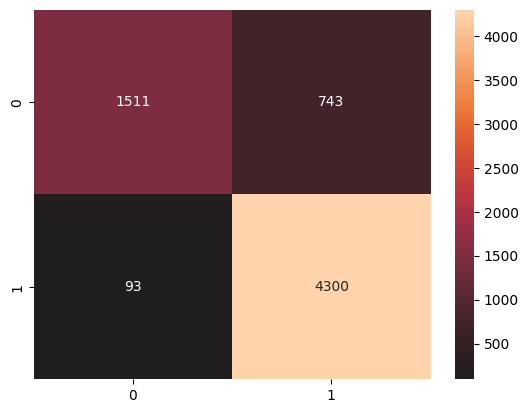

In [ ]:
cm = confusion_matrix(test_sent, 1 * (cnn_preds > 0.5))
sns.heatmap(cm, annot=True, center = True, fmt='g')

# Second way

In [ ]:
df['sentiment'] = df['rating'].apply(lambda rating: 2 if rating>=4 else 1 if rating==3 else 0)

## Class distribution

<ipython-input-30-e6270976116e>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df['sentiment'], palette={'0': 'r', '1': 'y', '2':'g'})


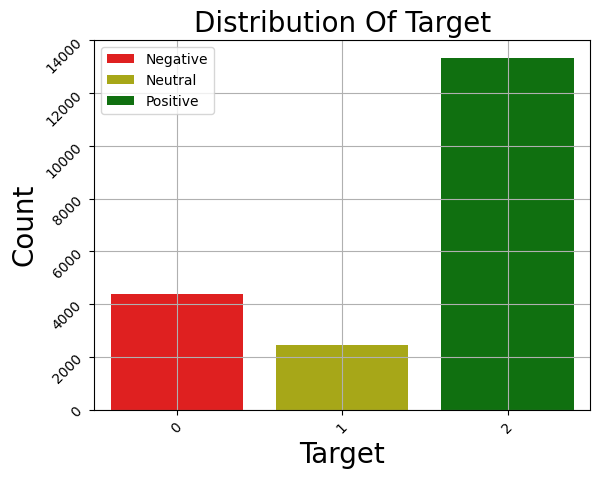

In [ ]:
sns.countplot(x=df['sentiment'], palette={'0': 'r', '1': 'y', '2':'g'})
plt.title('Distribution Of Target',fontsize=20)
plt.xlabel('Target',fontsize=20)
plt.ylabel('Count',fontsize=20)
plt.legend(["Negative", "Neutral", "Positive"])
plt.grid(True)
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

## Tokenize & vectorize texts

In [ ]:
train_texts, test_texts, train_sent, test_sent, MAX_LENGTH, index_of_words, tokenizer = preparatory_work()

## (NAME OF THE MODEL) model

In [ ]:
from keras.initializers import Constant




def getEmbeddingLayer(num_words, embedding_size, max_length, tokenizer, word2vec, Trainable = False):
  print("Размер embedding матрицы:", num_words, "x", embedding_size)
  embedding_matrix = np.zeros((num_words, embedding_size))
  for word, i in tokenizer.word_index.items():
    if i > num_words: #если индекс превышает кол-во слов в словаре, то скипаем
      continue
    embedding_vector = w2v[word] #получаем вектор соответствущий слову в модели word2vec
    if embedding_vector is not None:  #если слово отсутствует в словаре word2vec, то оно в матрице np.zeroes останется равным 0
      embedding_matrix[i] = embedding_vector #если слово найдено в словаре токенизатора, то в embedding_matrix проставляем вектор соответствующий слову

  embedding_layer = Embedding(input_dim = num_words,
                              output_dim = embedding_size,
                              embeddings_initializer = Constant(embedding_matrix),
                              input_length = max_length,
                              trainable = Trainable)
  return embedding_layer, embedding_matrix

In [ ]:

сети.
writers_embedding_layer, writers_embedding_matrix = getEmbeddingLayer(num_words, EMBEDDING_DIM, max_len, tokenizer, writers_w2v, Trainable = False)

In [ ]:


writers_embedding_layer, writers_embedding_matrix = getEmbeddingLayer(num_words, EMBEDDING_DIM, max_len, tokenizer, writers_w2v, Trainable = False)

### Train model

In [ ]:
log = LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=500)
log.fit(train_texts, train_sent)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=500)

### Test model

In [ ]:
ylog_pred = log.predict(test_texts)

print("Accuracy: {:.2f}%".format(accuracy_score(test_sent, ylog_pred) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(test_sent, ylog_pred, average='micro') * 100))
print("\nCOnfusion Matrix:\n", confusion_matrix(test_sent, ylog_pred))

Accuracy: 68.32%

F1 Score: 68.32

COnfusion Matrix:
 [[  79   19 1335]
 [  12  151  658]
 [  39   43 4311]]


-----------------------

# Conclusion: in the first case we obtained a score of 0.95 and in the second case 0.68.

# Thank you for your attention! ✊